In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from PIL import Image
## skelarn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

## skelarn -- models
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
## --------------------- Data Preparation ---------------------------- ##

## Read the Dataset
TRAIN_PATH = os.path.join(os.getcwd(), 'dataset.csv')
df = pd.read_csv(TRAIN_PATH)

df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=0, inplace=True)

df.drop(index=df[df["Age"] > 80].index.tolist(), axis=0, inplace=True)

In [3]:
## To features and target
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)

In [5]:
## Slice the lists
num_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categ_cols = ['Gender', 'Geography']

ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

In [11]:
num_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(num_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])

categ_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(categ_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

ready_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(ready_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [12]:
all_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('categ_pipeline', categ_pipeline),
    ('ready_pipeline', ready_pipeline)
])

In [13]:
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [17]:
## 2. prepare class_weights for solving imbalance dataset
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / np.sum(vals_count)  ## normalizing


In [18]:

dict_weights = {}
for i in range(2):  ## 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

## 3. Using SMOTE for over sampling
over = SMOTE(sampling_strategy=0.7)
X_train_resmapled, y_train_resampled = over.fit_resample(X_train_final, y_train)



In [25]:
with open('metrics.txt', 'w') as f:
    pass

In [26]:
def train_model(X_train, y_train, plot_name='', class_weight=None):
    """ A function to train model given the required train data """
    
    global clf_name

    clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=45, class_weight=class_weight)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test_final)
    
    ## Using f1_score
    score_train = f1_score(y_train, y_pred_train)
    score_test = f1_score(y_test, y_pred_test)
    
    clf_name = clf.__class__.__name__

    ## Plot the confusion matrix 
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cbar=False, fmt='.2f', cmap='Blues')
    plt.title(f'{plot_name}')
    plt.xticks(ticks=np.arange(2) + 0.5, labels=[False, True])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=[False, True])

    ## Save the plot locally
    plt.savefig(f'{plot_name}.png', bbox_inches='tight', dpi=300)
    plt.close()


    ## Write scores to a file
    with open('metrics.txt', 'a') as f:
            f.write(f'{clf_name} {plot_name}\n')
            f.write(f"F1-score of Training is: {score_train*100:.2f} %\n")
            f.write(f"F1-Score of Validation is: {score_test*100:.2f} %\n")
            f.write('----'*10 + '\n')


    return True

In [30]:
## 1. without considering the imabalancing data
train_model(X_train=X_train_final, y_train=y_train, plot_name='without-imbalance', class_weight=None)

## 2. with considering the imabalancing data using class_weights
train_model(X_train=X_train_final, y_train=y_train, plot_name='with-class-weights', class_weight=dict_weights)

## 3. with considering the imabalancing data using oversampled data (SMOTE)
train_model(X_train=X_train_resmapled, y_train=y_train_resampled, plot_name=f'with-SMOTE', class_weight=None)



True

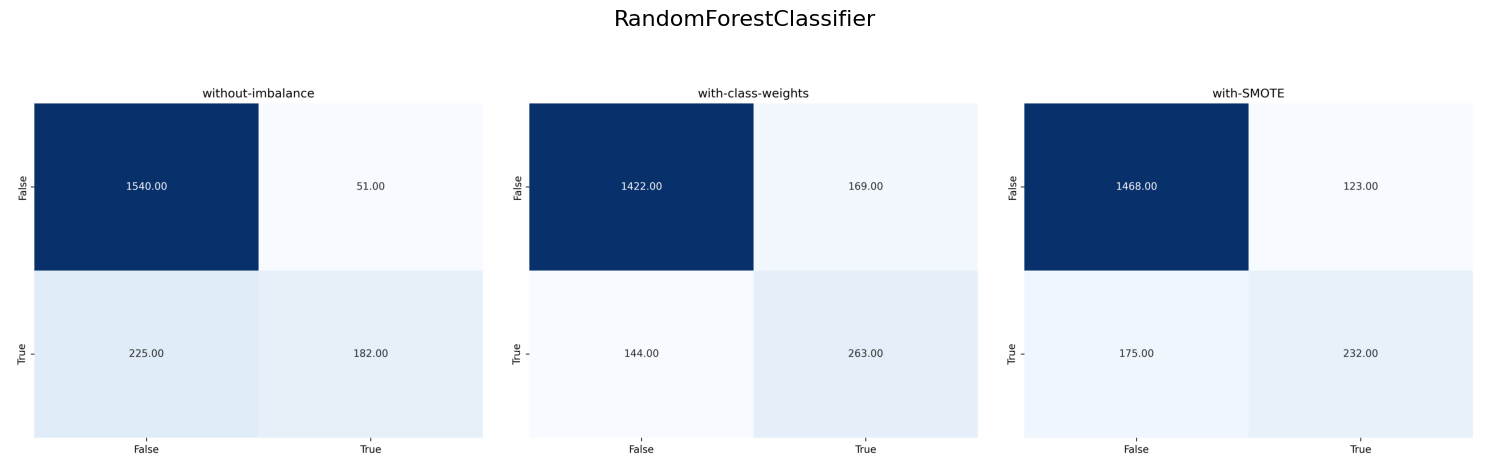

In [32]:

## Combine all conf matrix in one
confusion_matrix_paths = [f'./without-imbalance.png', f'./with-class-weights.png', f'./with-SMOTE.png']
## Load and plot each confusion matrix
plt.figure(figsize=(15, 5))  # Adjust figure size as needed
for i, path in enumerate(confusion_matrix_paths, 1):
    img = Image.open(path)
    plt.subplot(1, len(confusion_matrix_paths), i)
    plt.imshow(img)
    plt.axis('off')  # Disable axis for cleaner visualization


## Save combined plot locally
plt.suptitle(clf_name, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'conf_matrix.png', bbox_inches='tight', dpi=300)

## Delete old image files
for path in confusion_matrix_paths:
    os.remove(path)